<img src="logo.png">
## RNNs in Signal Processing and Human System Interaction
#### Krzysztof Czuszynski | _Department of Biomedical Engineering_ | _GUT_

### PART 1: RNNs in prediction of medical data

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\qlast\Anaconda3\envs\py35\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Load the data and see what we got:

In [2]:
biosignals=pd.read_csv('data/biosignals.csv')
print(biosignals.shape)
biosignals.head()

(75000, 4)


,CNAP,PPGf,dZ,ddZ
0,71.953918,1.330529,-0.547768,1.037937
1,71.969177,1.336272,-0.551443,1.053503
2,71.908141,1.336272,-0.553988,1.103314
3,71.938659,1.347758,-0.546354,1.051428
4,71.831846,1.345605,-0.555118,1.059730


In [3]:
biosignals.describe()

,CNAP,PPGf,dZ,ddZ
count,75000.000000,7.500000e+04,7.500000e+04,7.500000e+04
mean,86.354927,-1.708496e-15,1.202365e-15,4.227065e-15
std,19.520420,1.000007e+00,1.000007e+00,1.000007e+00
min,49.767300,-2.947375e+00,-2.680601e+00,-3.722135e+00
25%,71.187152,-6.867407e-01,-5.836731e-01,-7.137528e-01
50%,84.847791,2.109850e-02,-9.456901e-02,-2.613020e-01
75%,96.200504,7.253482e-01,5.189315e-01,6.031280e-01
max,132.959487,2.348497e+00,2.962190e+00,4.079527e+00


Let's display how our target looks like:

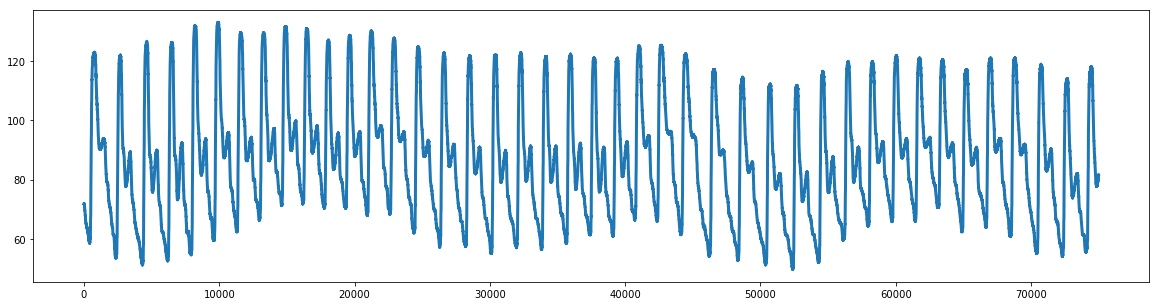

In [4]:
plt.figure(figsize=(20,5))
plt.plot(biosignals['CNAP'],linewidth=3)
plt.show()

Ok, why not to tak a closer look at single heart cycle:

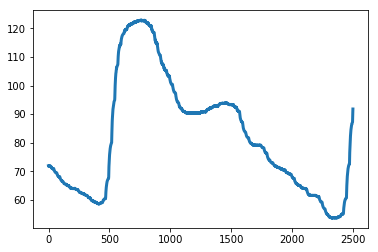

In [5]:
biosignals_short = biosignals.head(2500)
plt.plot(biosignals_short['CNAP'],linewidth=3)
plt.show()

Our input waveforms:

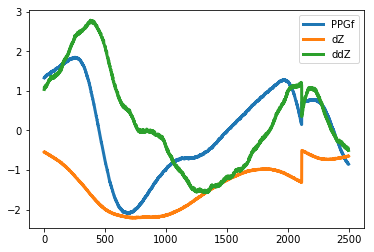

In [6]:
plt.plot(biosignals_short.iloc[:,1:],linewidth=3)
plt.legend(biosignals_short.columns[1:])
plt.show()

Now it is time to prepare our data: split it to inputs/targets and later to training/testing sets.

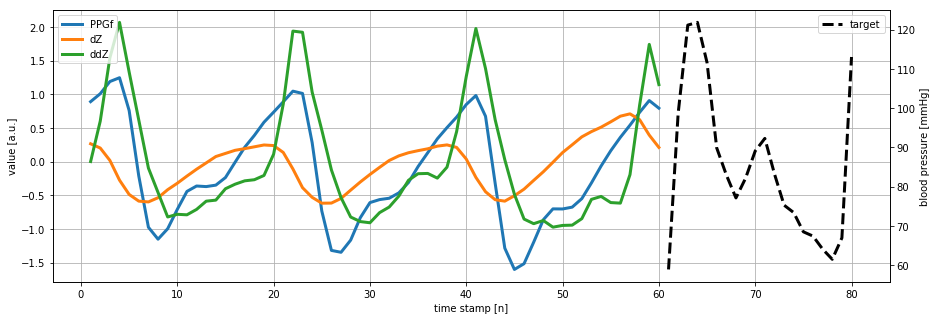

In [7]:
select_every_nth = 100  #-- we won't use waveforms sampled with fs=1kHz -> new effective sampling frequency = fs/select_every_nth
inp_steps = 20*3        #-- length of input sequence
out_steps = 20          #-- length of output sequence
shift = 20              #-- shift/time delay between output and input sequence (shift must be >=0)

ratio = 0.6      # how much of the data we want to train our model on -> e.g. ratio = 0.6 means 60% training / 40% testing

%run Functions.ipynb
X_train, X_test, _Y_train, _Y_test = SmartDataChop(\
                  biosignals, select_every_nth, inp_steps, out_steps, \
                  shift, ratio, tail_for_testing=False) #-- tail for testing = False -> easy case

#--------------plot------------
test_case = 10

plt.figure(figsize=(15,5))
plt.plot(np.arange(1,X_train[test_case,:].shape[0]+1), 
         X_train[test_case,:], linewidth=3)
plt.grid()
plt.legend(biosignals.columns[1:], loc=2)
plt.xlabel('time stamp [n]')
plt.ylabel('value [a.u.]')

plt2 = plt.twinx()
plt2.plot(np.arange(1,_Y_train[test_case,:].shape[0]+1)+X_train[0,:].shape[0]-_Y_train[test_case,:].shape[0]+shift,
         _Y_train[test_case,:],'k--', label='target', linewidth=3)
plt2.legend(loc=1)
plt2.set_ylabel('blood pressure [mmHg]')
plt.show()

In [8]:
print('X_train shape: {}'.format(X_train.shape))
print('Y_train shape: {}'.format(_Y_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('Y_test shape: {}'.format(_Y_test.shape))

X_train shape: (1500, 60, 3)
Y_train shape: (1500, 20)
X_test shape: (1000, 60, 3)
Y_test shape: (1000, 20)


Original target is in the range ~80-130 mmHg. Lets not normalize it but just scale down so the network can learn it faster and wont have to look for the baseline for too many epochs.

In [9]:
factor = 100
Y_train =_Y_train/factor
Y_test = _Y_test/factor

In [10]:
n_inputs = X_train.shape[2]
n_units   = 10
n_outputs = 1

tf.reset_default_graph()
tf.set_random_seed(seed=1) # for reproducibility

#--- queue will shuffle our examples, feed our batches and fill up whenever 
#ends up with elements < min_after_dequeue after the dequeue_many op
minibatch_size = 32
queue = tf.RandomShuffleQueue(capacity=Y_train.shape[0], 
                              min_after_dequeue=minibatch_size+10, 
                              dtypes=[tf.float32,tf.float32], 
                              shapes=[[inp_steps,n_inputs],[out_steps]])

#--- fill queue with our training examples : inputs and targets
enqueue = queue.enqueue_many((X_train,Y_train))
#--- whenever X_batch or y_batch is requested the dequeue_many evaluates
X_batch, y_batch = queue.dequeue_many(minibatch_size)

X = tf.placeholder_with_default(X_batch, [None, inp_steps, n_inputs])
y = tf.placeholder_with_default(y_batch, [None, out_steps])
#d = tf.placeholder_with_default(0.8, []) #-- for dropout

cell = tf.contrib.rnn.GRUCell(num_units=n_units, activation=tf.nn.relu)  
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size=n_outputs, activation=None)

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)


print('Outputs shape before:', outputs.shape)
outputs = outputs[:,-out_steps:,0] #in case of out_steps!=inp_steps (in this approach out_steps<=inp_steps)
print('Outputs shape after:', outputs.shape)

Outputs shape before: (?, 60, 1)
Outputs shape after: (?, 20)


In [11]:
#--- cell with helper lines
#--- we can use all of these useful things: layers, dropout, OPW
#layers = [tf.contrib.rnn.GRUCell(num_units = n_units, activation=tf.nn.relu) for layer in range (n_layers)]
#layers_d = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=d, seed=3) for cell in layers]
#multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
#cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size=n_outputs, activation=None)

In [12]:
lr = 0.005

#loss = tf.losses.mean_squared_error(labels=y*factor, predictions=outputs*factor)
loss = tf.sqrt(tf.reduce_mean(tf.squared_difference(y*factor, outputs*factor))) #RMSE just to interpret the loss

optimizer = tf.train.AdamOptimizer(learning_rate=lr)
tr_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [13]:
epochs = 200
steprefr = 5   #-- step refresh: update loss

n_threads = 1
qr = tf.train.QueueRunner(queue, [enqueue] * n_threads)
tf.train.add_queue_runner(qr) 

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    sess.run(init)
        
    train_loss=[]
    test_loss=[]
        
    for epoch in range(1,epochs+1):                
        for miniBatch in range(X_train.shape[0]//minibatch_size):
            sess.run(tr_op) #!
        
        if(epoch % steprefr == 0):
            # remember about dropout if applied
            lossTR = loss.eval(feed_dict={X: X_train, y: Y_train})
            lossTE = loss.eval(feed_dict={X: X_test,  y: Y_test})
            
            train_loss.append(lossTR)
            test_loss.append(lossTE)
            
            print("Epoch: {0}\tLoss train: {1:.3f}  Loss test: {2:.3f}".format(epoch,lossTR,lossTE))
                            
    # remember about dropout if applied
    y_pred = sess.run(outputs, feed_dict={X: X_test})             
        
    coord.request_stop()  
    coord.join(threads)    

Epoch: 5	Loss train: 10.818  Loss test: 10.670
Epoch: 10	Loss train: 7.841  Loss test: 7.787
Epoch: 15	Loss train: 6.007  Loss test: 5.967
Epoch: 20	Loss train: 5.015  Loss test: 4.993
Epoch: 25	Loss train: 4.724  Loss test: 4.742
Epoch: 30	Loss train: 4.145  Loss test: 4.145
Epoch: 35	Loss train: 3.962  Loss test: 3.977
Epoch: 40	Loss train: 3.788  Loss test: 3.783
Epoch: 45	Loss train: 3.689  Loss test: 3.688
Epoch: 50	Loss train: 3.512  Loss test: 3.546
Epoch: 55	Loss train: 3.327  Loss test: 3.340
Epoch: 60	Loss train: 3.279  Loss test: 3.298
Epoch: 65	Loss train: 3.302  Loss test: 3.313
Epoch: 70	Loss train: 3.160  Loss test: 3.162
Epoch: 75	Loss train: 3.089  Loss test: 3.096
Epoch: 80	Loss train: 3.150  Loss test: 3.136
Epoch: 85	Loss train: 3.035  Loss test: 3.020
Epoch: 90	Loss train: 2.921  Loss test: 2.930
Epoch: 95	Loss train: 2.916  Loss test: 2.936
Epoch: 100	Loss train: 2.768  Loss test: 2.766
Epoch: 105	Loss train: 3.059  Loss test: 3.087
Epoch: 110	Loss train: 2.716  L

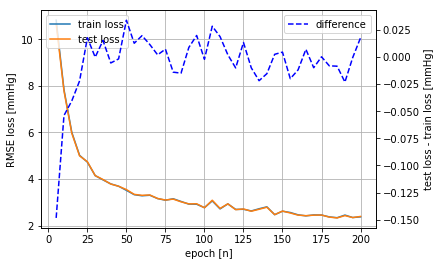

In [14]:
plt.plot(np.arange(steprefr,epochs+1,steprefr), train_loss, label='train loss')
plt.plot(np.arange(steprefr,epochs+1,steprefr), test_loss,  label='test loss')
plt.legend(loc=2)
plt.xlabel('epoch [n]')
plt.ylabel('RMSE loss [mmHg]')
plt.grid()
plt2 = plt.twinx()
plt2.plot(np.arange(steprefr,epochs+1,steprefr), (np.asarray(test_loss)-np.asarray(train_loss)),'b--', label='difference')
plt2.legend(loc=1)
plt2.set_ylabel('test loss - train loss [mmHg]')
plt.show()

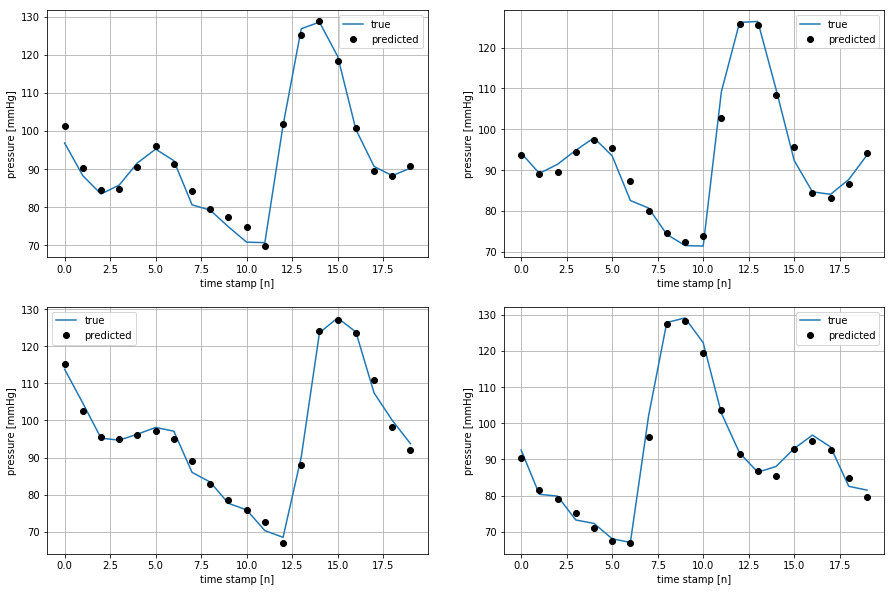

In [15]:
num=np.random.randint(100)

from matplotlib import gridspec
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(Y_test[num,:]*factor, label="true")
ax1.plot(y_pred[num,:]*factor, 'ko', label="predicted")
ax1.legend()
ax1.set_ylabel('pressure [mmHg]')
ax1.set_xlabel('time stamp [n]')
ax1.grid()

ax2 = fig.add_subplot(gs[0,1])
ax2.plot(Y_test[num+50,:]*factor, label="true")
ax2.plot(y_pred[num+50,:]*factor, 'ko', label="predicted")
ax2.legend()
ax2.set_ylabel('pressure [mmHg]')
ax2.set_xlabel('time stamp [n]')
ax2.grid()

ax3 = fig.add_subplot(gs[1,0])
ax3.plot(Y_test[num+150,:]*factor, label="true")
ax3.plot(y_pred[num+150,:]*factor, 'ko', label="predicted")
ax3.legend()
ax3.set_ylabel('pressure [mmHg]')
ax3.set_xlabel('time stamp [n]')
ax3.grid()

ax4 = fig.add_subplot(gs[1,1])
ax4.plot(Y_test[num+250,:]*factor, label="true")
ax4.plot(y_pred[num+250,:]*factor, 'ko', label="predicted")
ax4.legend()
ax4.set_ylabel('pressure [mmHg]')
ax4.set_xlabel('time stamp [n]')
ax4.grid()

In [16]:
#lets see the average error on example from test set:
test_case=num
factor*np.sum(np.abs(y_pred[test_case,:]-Y_test[test_case,:]))/out_steps

1.4160977475765157